In [22]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [40]:
class Particle:
    def __init__(self, type, x, k_off, k_off_flank, k_move):
        self.type = type
        self.x = x
        self.k_off = k_off
        self.k_off_flank = k_off_flank
        self.k_move = k_move


    def move(self, tract, dx):
        """
        move particle dx sites to the right
        """
        self.x += dx
        tract.occupied_sites[self.x] = 1
        tract.occupied_sites[self.x - dx] = 0


    def dissociate(self, tract):
        """
        dissociate particle from tract
        """
        tract.occupied_sites[self.x] = 0
        tract.n_free_particles += 1
        tract.particles.remove(self)


    def simulate_particle(self, tract):
        """
        simulate one time step for a particle
        """
        # roll to see if particle dissociates
        off_check = self.k_off_flank if self.x == tract.length - 1 or self.x == 0 else self.k_off
        if np.random.rand() < off_check:
            self.dissociate(tract)
            return
        
        left_roll = np.random.rand()
        right_roll = np.random.rand()

        # check if either neighboring site is occupied or out of bounds
        left_avail = self.x-1 > 0 and tract.occupied_sites[self.x - 1] == 0 and left_roll < self.k_move
        right_avail = self.x+1 < tract.length - 1 and tract.occupied_sites[self.x + 1] == 0 and right_roll < self.k_move

        # go left if better roll or only left is available
        move_left = ( (left_avail and right_avail) and left_roll < right_roll ) or (left_avail and not right_avail) 
        
        if move_left:
            self.move(tract, -1)
            return
        
        # move right is true if roll beats k_move
        if right_avail:
            self.move(tract, 1)
            return
        
        # no move, do nothing
        return
    

particle_properties = {
    'test': {'k_off': 0.01, 'k_off_flank': 0.1, 'k_move': 0.1},
}


class RepeatTract:
    def __init__(self, N_repeats, motif, n_free_particles, k_on):
        self.N_repeats = N_repeats
        self.motif = motif
        #self.length = N_repeats * len(motif)
        self.length = N_repeats
        self.particles = []
        self.occupied_sites = np.zeros(self.length)
        self.n_free_particles = n_free_particles
        self.k_on = k_on
        self.init_particles()

    def init_particles(self):
        """
        initialize particles on the tract
        """
        # create a n_free_particle random 0, 1 on the tract
        self.occupied_sites = np.zeros(self.length)
        indices = np.random.choice(self.length, self.n_free_particles, replace=False)
        self.occupied_sites[indices] = 1
        self.initial_state = self.occupied_sites.copy()  # Save a copy of the initial state
        print("Initiated particles on the tract: ")
        print(self.occupied_sites)
        return



    def add_particle(self, type, x, k_off, k_off_flank, k_move):
        """
        add a particle to the tract at position x
        """
        if self.occupied_sites[x] == 1:
            # pick unoccupied site nearest to x efficiently, have to get indices of occupied sites
            indices = np.where(self.occupied_sites == 0)[0]
            x = indices[np.argmin(np.abs(indices - x))]

        self.particles.append(Particle(type, x, k_off, k_off_flank, k_move))
        self.occupied_sites[x] = 1
        
        return


    def add_free_particles(self, type='test'):
        """
        add free particles to the tract based on k_on and n_free_particles
        """
        # roll to see how many particles to add based on n_free_particles and k_on
        n_add = np.random.poisson(self.n_free_particles * self.k_on)
        #print(f"add {n_add} particles, {self.n_free_particles} free particles, k_on: {self.k_on}")
        for i in range(n_add):
            if self.n_free_particles == 0:
                return
            self.add_particle(type, np.random.randint(self.length), **particle_properties[type])
            self.n_free_particles -= 1
        return


    def simulate_n_steps(self, n_steps):
        """
        simulate n_steps for all particles in the tract
        """
        for i in range(n_steps):
            #print("Step: ", i)
            # shuffle particles to avoid bias
            np.random.shuffle(self.particles)
            for particle in self.particles:
                #print(f"loc: {particle.type} -  {particle.x} ")
                particle.simulate_particle(self)
            
            self.add_free_particles()
        return
    

    def simulate_multiple_possibilities(self, n_steps, n_simulations):
        """
        simulate n_simulations of n_steps and return results
        as if we are doing bulk sequencing of the tract
        """
        print("stop doin the corn")
        results = []
        for i in range(n_simulations):
            #print("Simulate possibility: ", i)
            self.init_particles()
            self.occupied_sites = self.initial_state.copy()  # Reset to the initial state before each simulation
            self.simulate_n_steps(n_steps)
            results.append(self.occupied_sites.copy())  # Append a copy to avoid modifying the original array
        return results
    

    def plot_tract_histogram(self, results):
        """
        Plot a histogram of occupied sites in the tract based on simulation results.
        """
        counts = np.sum(results, axis=0)

        #print(counts)

        plt.bar(range(self.length), counts)
        plt.xlabel("Position in Tract")
        plt.ylabel("Frequency")
        plt.title("Occupied Sites Histogram")
        plt.show()

        return


Initiated particles on the tract: 
[1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0.]
stop doin the corn
Initiated particles on the tract: 
[1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 1.]
Initiated particles on the tract: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

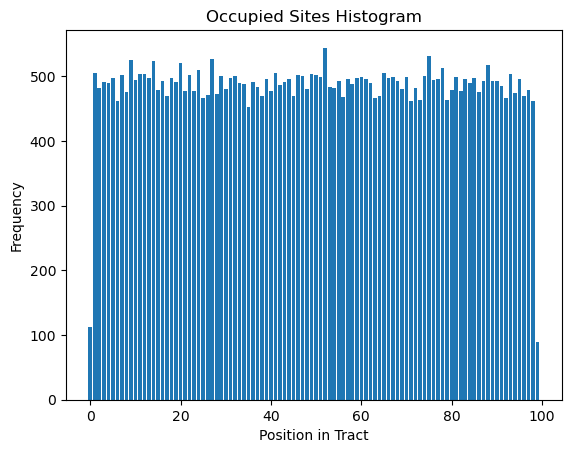

In [41]:
# create a tract with 100 repeats of a motif and 10 free particles
#              N_repeats, motif, n_free_particles, k_on)
tract = RepeatTract(100, 'ATCG', 50, 0.1)
# sum columns to get number of particles at each site
results = np.array( tract.simulate_multiple_possibilities(1000, 1000) ) #.sum(axis=0)
# add results together to simulate bulk sequencing
#results = np.array(results).sum(axis=0)
print(results[0])

tract.plot_tract_histogram(results)